In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pyproj
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")




In [2]:
clean_df = pd.read_csv('../DataSets/clean_divar_data.csv')
raw_df = pd.read_csv('../DataSets/Divar.csv', usecols=['location_latitude','location_longitude'])

In [3]:
clean_df['location_latitude'] = raw_df['location_latitude']
clean_df['location_longitude'] = raw_df['location_longitude']

In [4]:
# Remove rows with invalid geographic coordinates (global bounds)
valid_geo_mask = (
    clean_df['location_latitude'].between(-90, 90) & 
    clean_df['location_longitude'].between(-180, 180)
)
df = clean_df[valid_geo_mask].copy()
print(f"Remaining rows after geographic filtering: {len(df)}")

Remaining rows after geographic filtering: 655608


In [ ]:
# =====================================================
# PART 1: Feature Selection and Data Preparation
# =====================================================


clustering_features = [
    'transformable_price',  # Price (most important for user preference)
    'building_size',        # Building area (key space factor)
    'rooms_count',          # Number of rooms (family size consideration)
    'has_elevator',         # Elevator (comfort/accessibility)
    'has_parking',          # Parking (essential urban amenity)
    'has_balcony',          # Balcony (lifestyle preference)
    'building_age',         # Age of building (quality/modernity)
    'location_latitude',    # Geographic location
    'location_longitude'    # Geographic location
]

print("Selected features for clustering:")
for i, feature in enumerate(clustering_features, 1):
    print(f"{i}. {feature}")

Selected features for clustering:
1. transformable_price
2. building_size
3. rooms_count
4. has_elevator
5. has_parking
6. has_balcony
7. building_age
8. location_latitude
9. location_longitude


In [6]:

# Create clustering dataset
df_clustering = df[clustering_features].copy()

print(f"\nInitial dataset shape: {df_clustering.shape}")
print("\nMissing values before cleaning:")
print(df_clustering.isnull().sum())

# Handle missing values
df_clustering = df_clustering.dropna()
print(f"\nDataset shape after removing missing values: {df_clustering.shape}")



Initial dataset shape: (655608, 9)

Missing values before cleaning:
transformable_price    0
building_size          0
rooms_count            0
has_elevator           0
has_parking            0
has_balcony            0
building_age           0
location_latitude      0
location_longitude     0
dtype: int64

Dataset shape after removing missing values: (655608, 9)


In [7]:

# =====================================================
# PART 2: Convert Geographic Coordinates to UTM
# =====================================================

print("\nConverting geographic coordinates to UTM...")

# Set up UTM projection for Iran (Zone 39N covers most of Iran)
transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:32639', always_xy=True)

utm_x_coords = []
utm_y_coords = []

for idx, row in df_clustering.iterrows():
    try:
        # Transform longitude, latitude to UTM x, y
        x, y = transformer.transform(row['location_longitude'], row['location_latitude'])
        utm_x_coords.append(x)
        utm_y_coords.append(y)
    except Exception as e:
        # In case of transformation error, use NaN
        utm_x_coords.append(np.nan)
        utm_y_coords.append(np.nan)

# Add UTM coordinates to dataframe
df_clustering['utm_x'] = utm_x_coords
df_clustering['utm_y'] = utm_y_coords

# Remove rows with invalid UTM coordinates
df_clustering = df_clustering.dropna(subset=['utm_x', 'utm_y'])

# Remove original lat/lon columns for clustering (use UTM instead)
df_clustering = df_clustering.drop(['location_latitude', 'location_longitude'], axis=1)

print(f"Final dataset shape after UTM conversion: {df_clustering.shape}")


Converting geographic coordinates to UTM...
Final dataset shape after UTM conversion: (655608, 9)


In [8]:

# =====================================================
# PART 3: K-Means Clustering with 10 Clusters
# =====================================================

print("\nApplying K-Means clustering with k=10...")

# Standardize all features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Apply K-means with 10 clusters
kmeans_10 = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters_10 = kmeans_10.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustering['cluster_10'] = clusters_10

print(f"Clustering completed. Cluster distribution:")
cluster_counts = pd.Series(clusters_10).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} properties ({count/len(clusters_10)*100:.1f}%)")



Applying K-Means clustering with k=10...
Clustering completed. Cluster distribution:
Cluster 0: 59836 properties (9.1%)
Cluster 1: 77821 properties (11.9%)
Cluster 2: 70609 properties (10.8%)
Cluster 3: 95174 properties (14.5%)
Cluster 4: 8760 properties (1.3%)
Cluster 5: 51496 properties (7.9%)
Cluster 6: 36472 properties (5.6%)
Cluster 7: 43904 properties (6.7%)
Cluster 8: 148499 properties (22.7%)
Cluster 9: 63037 properties (9.6%)


NameError: name 'centers_utm_x' is not defined

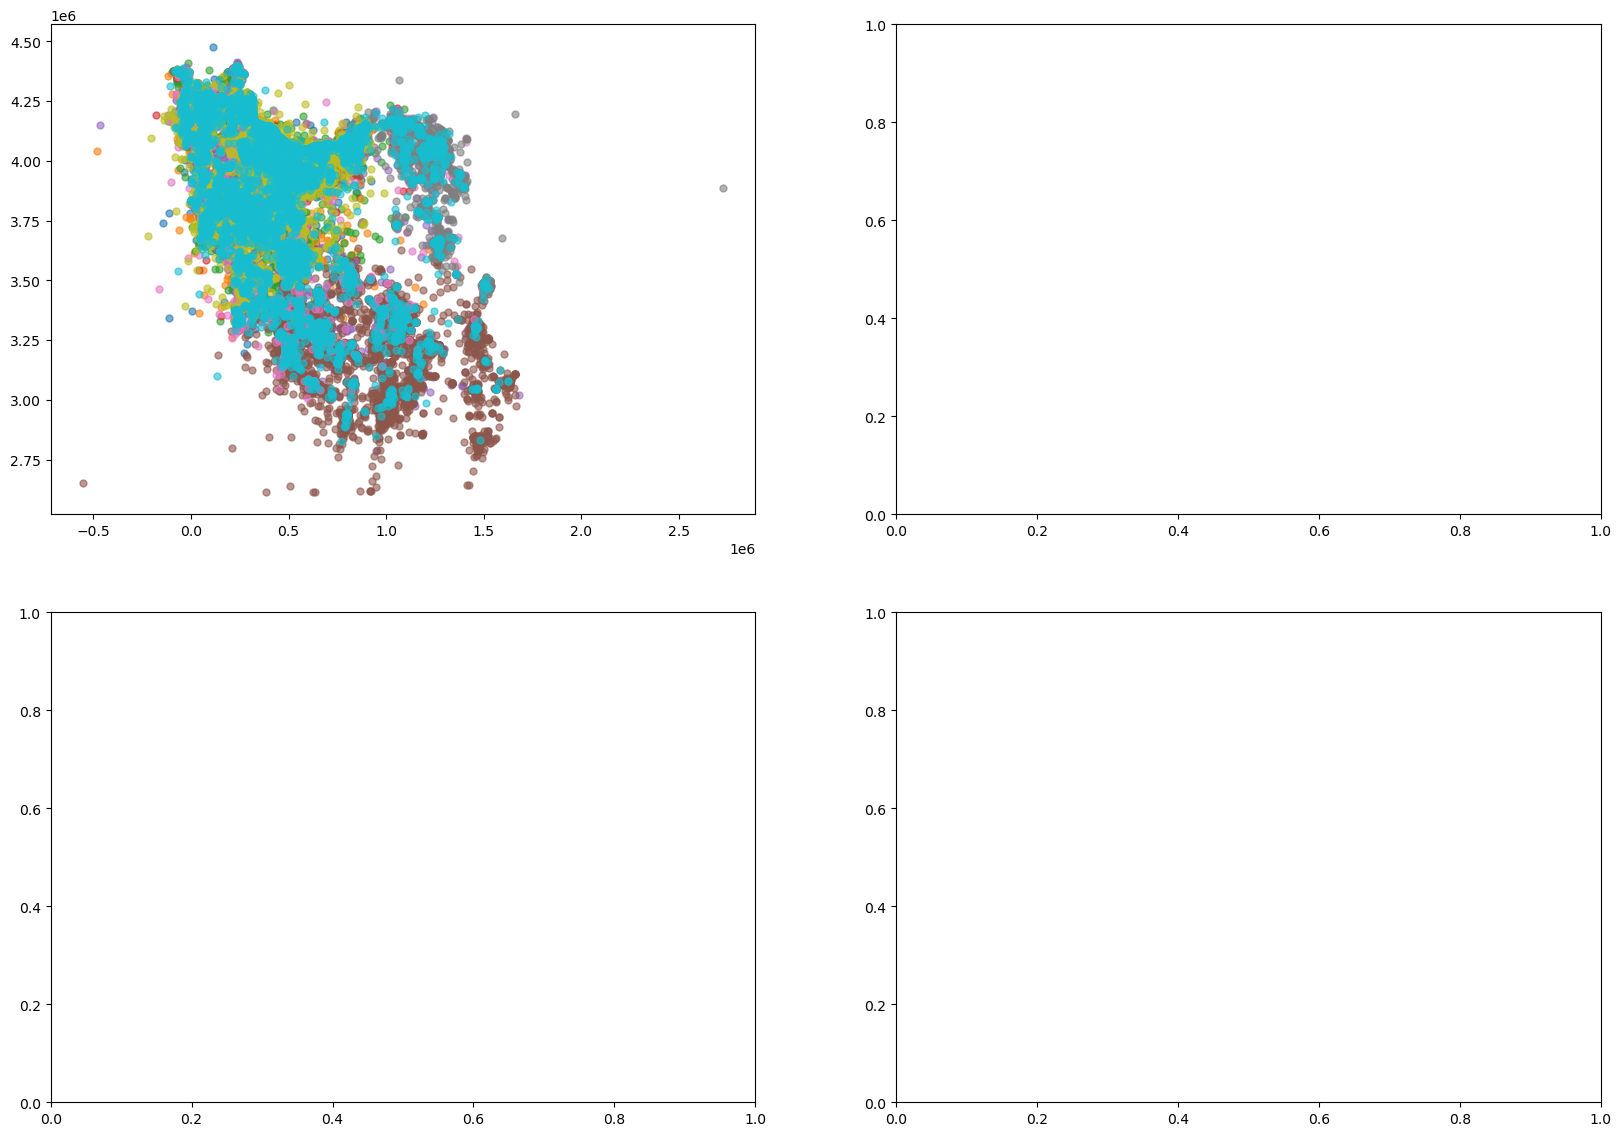

In [9]:

# =====================================================
# PART 4: Visualization 
# =====================================================


# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
(ax1, ax2), (ax3, ax4) = axes

# Use a modern, distinct color palette
colors = plt.cm.get_cmap("tab10", 10).colors

# --------------------------
# Plot 1: UTM coordinates
# --------------------------
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    ax1.scatter(
        cluster_data['utm_x'], cluster_data['utm_y'], 
        c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=25
    )

ax1.scatter(
    centers_utm_x, centers_utm_y, 
    c='black', marker='X', s=200, edgecolors='white', linewidths=2, 
    label='Centroids'
)
ax1.set(
    xlabel='UTM X (meters)', ylabel='UTM Y (meters)', 
    title='Geographic Distribution of Clusters'
)
ax1.grid(True, alpha=0.3)

# --------------------------
# Plot 2: Price vs UTM X
# --------------------------
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    ax2.scatter(
        cluster_data['utm_x'], cluster_data['transformable_price'], 
        c=[colors[i]], alpha=0.6, s=25
    )

ax2.scatter(
    centers_utm_x, centers_price, 
    c='black', marker='X', s=200, edgecolors='white', linewidths=2
)
ax2.set(
    xlabel='UTM X (meters)', ylabel='Transformable Price', 
    title='Price vs Geographic Location'
)
ax2.grid(True, alpha=0.3)

# --------------------------
# Plot 3: Price vs Building Size
# --------------------------
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    ax3.scatter(
        cluster_data['building_size'], cluster_data['transformable_price'], 
        c=[colors[i]], alpha=0.6, s=25
    )

ax3.scatter(
    centers_building_size, centers_price, 
    c='black', marker='X', s=200, edgecolors='white', linewidths=2
)
ax3.set(
    xlabel='Building Size (m²)', ylabel='Transformable Price', 
    title='Price vs Building Size'
)
ax3.grid(True, alpha=0.3)

# --------------------------
# Plot 4: UTM Y vs Building Size
# --------------------------
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    ax4.scatter(
        cluster_data['building_size'], cluster_data['utm_y'], 
        c=[colors[i]], alpha=0.6, s=25
    )

ax4.scatter(
    centers_building_size, centers_utm_y, 
    c='black', marker='X', s=200, edgecolors='white', linewidths=2
)
ax4.set(
    xlabel='Building Size (m²)', ylabel='UTM Y (meters)', 
    title='Building Size vs Geographic Location'
)
ax4.grid(True, alpha=0.3)

# --------------------------
# Shared Formatting
# --------------------------
for ax in axes.flatten():
    ax.title.set_fontsize(14)
    ax.title.set_fontweight('bold')
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)

# Place a single legend outside the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels, 
    loc='center right', bbox_to_anchor=(1.1, 0.5), 
    title="Clusters", fontsize=10
)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for legend
plt.show()



In [ ]:

# =====================================================
# PART 5: Cluster Analysis
# =====================================================

print("\n" + "="*60)
print("CLUSTER ANALYSIS SUMMARY")
print("="*60)

print("\nCluster characteristics (average values):")
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} properties - {len(cluster_data)/len(df_clustering)*100:.1f}%):")
    print(f"  • Average Price: {cluster_data['transformable_price'].mean():,.0f}")
    print(f"  • Average Building Size: {cluster_data['building_size'].mean():.0f} m²")
    print(f"  • Average Rooms: {cluster_data['rooms_count'].mean():.1f}")
    print(f"  • Average Building Age: {cluster_data['building_age'].mean():.1f} years")
    print(f"  • Has Elevator: {cluster_data['has_elevator'].mean()*100:.0f}%")
    print(f"  • Has Parking: {cluster_data['has_parking'].mean()*100:.0f}%")
    print(f"  • Has Balcony: {cluster_data['has_balcony'].mean()*100:.0f}%")
    print(f"  • Geographic center: UTM({cluster_data['utm_x'].mean():.0f}, {cluster_data['utm_y'].mean():.0f})")

print(f"\nClustering completed successfully!")
print(f"Total properties clustered: {len(df_clustering)}")
print(f"Features used: {len(feature_names)}")

# Save results for next parts
df_clustering.to_pickle('../DataSets/clustering_results_part1.pkl')
print(f"\nResults saved to 'clustering_results_part1.pkl'")



CLUSTER ANALYSIS SUMMARY

Cluster characteristics (average values):

Cluster 0 (59836 properties - 9.1%):
  • Average Price: 0
  • Average Building Size: 142 m²
  • Average Rooms: 2.2
  • Average Building Age: 17.4 years
  • Has Elevator: 1%
  • Has Parking: 98%
  • Has Balcony: 99%
  • Geographic center: UTM(472055, 3900796)

Cluster 1 (77821 properties - 11.9%):
  • Average Price: 0
  • Average Building Size: 94 m²
  • Average Rooms: 1.5
  • Average Building Age: 12.0 years
  • Has Elevator: 37%
  • Has Parking: 0%
  • Has Balcony: 100%
  • Geographic center: UTM(461107, 3917249)

Cluster 2 (70609 properties - 10.8%):
  • Average Price: 0
  • Average Building Size: 485 m²
  • Average Rooms: 0.2
  • Average Building Age: -0.6 years
  • Has Elevator: 35%
  • Has Parking: 100%
  • Has Balcony: 100%
  • Geographic center: UTM(439164, 3944744)

Cluster 3 (95174 properties - 14.5%):
  • Average Price: 1
  • Average Building Size: 150 m²
  • Average Rooms: 2.1
  • Average Building Age: 5.1

In [ ]:

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

# --------------------------
# 1. Fit MiniBatchKMeans
# --------------------------
mbkmeans = MiniBatchKMeans(
    n_clusters=10,          # same number of clusters
    random_state=42,
    batch_size=1024,        # adjust batch size based on RAM
    max_iter=300,
    n_init=10
)
clusters_10 = mbkmeans.fit_predict(X_scaled)

# --------------------------
# 2. Compute clustering metrics
# --------------------------
# For large datasets, sample 10k points to speed up silhouette score
if len(X_scaled) > 10000:
    sample_idx = np.random.choice(len(X_scaled), size=10000, replace=False)
    X_sample = X_scaled[sample_idx]
    clusters_sample = clusters_10[sample_idx]
else:
    X_sample = X_scaled
    clusters_sample = clusters_10

silhouette_avg = silhouette_score(X_sample, clusters_sample)
calinski_score = calinski_harabasz_score(X_sample, clusters_sample)

# --------------------------
# 3. Display metrics
# --------------------------
print("\nClustering Quality Metrics (MiniBatchKMeans):")
print(f"  • Silhouette Score: {silhouette_avg:.3f} (range: -1 to 1, higher is better)")
print(f"  • Calinski-Harabasz Score: {calinski_score:.2f} (higher is better)")
print(f"  • Within-cluster Sum of Squares (WCSS): {mbkmeans.inertia_:.2f}")



Clustering Quality Metrics (MiniBatchKMeans):
  • Silhouette Score: 0.245 (range: -1 to 1, higher is better)
  • Calinski-Harabasz Score: 1444.37 (higher is better)
  • Within-cluster Sum of Squares (WCSS): 2580241.07
